# Tutorial #5 :: EKF based SLAM
In the particle filter tutorial we showed how range estimates from anchor nodes with *known* locations can be used to localize an unknown node based on maximum likelihood estimation. But what happens if we don't know the location of each anchor *a priori*? This is the problem of **simultaneous localization and mapping**, or SLAM. 

Luckily, we can easily adopt the EKF discussed in an earlier tutorial for SLAM--we need only add the unknown anchor locations to the state vector. For convenience, let's use the same exact simulation used in the particle filter. 

In [153]:
import numpy as np

# environment
BOUNDX = [-5,5]
BOUNDY = [-5,5]
# Path shape and speed
PATHRAD = 3.5
PATHVEL = 1.0
# anchors
ANCRAD = 4.5
NUMANC = 4
# timing
TSTOP = 20
TSTEP = (1.0/10)

# true path
times = np.arange(TSTOP, step=TSTEP)
path_angle = times*(PATHVEL/PATHRAD)
path_x = np.cos(path_angle)*PATHRAD
path_y = np.sin(path_angle)*PATHRAD
path_xy = np.stack([path_x,path_y], axis=1)

# anchor positions
anc_angles = [i*(2*np.pi)/NUMANC for i in range(NUMANC)]
anc_x = [ANCRAD*np.cos(angle)for angle in anc_angles]
anc_y = [ANCRAD*np.sin(angle)for angle in anc_angles]
anc_xy = np.stack([anc_x,anc_y], axis=1)

Next, we'll define our EKF update and linearization functions exactly as before:

In [154]:
import scipy.linalg

def ekfUpdate(fcn_state,x,P,fcn_meas,z,Q,R):
    x1,A = linearize(fcn_state, x)
    P = A*P*A.T + Q
    z1,H = linearize(fcn_meas, x1)
    P12 = P*H.T
    R = scipy.linalg.cholesky( H*P12 + R )
    U = P12*np.linalg.pinv(R)
    dz = (z-z1)
    x = x1 +  U * np.linalg.pinv(R.T)*dz
    P = P - U*U.T
    return (x, P)

def linearize(fcn, x):
    z = fcn(x)
    n = len(x)
    m = len(z)
    A = np.mat( np.zeros( (m,n) ) )
    h = n*np.spacing(1)
    for k in range(n):
        x1 = np.matrix(x, dtype='complex')
        x1[k] += h*1j
        A[:,k] = fcn(x1).imag / h
    return (z, A)

The difference now comes in the form of the process (state) equations and the measurement equations. For convenience, let's go ahead and assume that we have 4 anchor nodes, as is indeed the case. Each anchor node will introduce an extra x and y coordinate to the state. 

One important distinction is that, for SLAM to be feasible, we need the unknown node to have some notion of relative displacement between range measurements.  This helps in essentially triangulating the unkonwn anchor nodes by combining multiple range measurements at different time steps. 

We define the process equation as follows.

In [155]:
def fcn_state(state, delta_t):
    # mobile node
    x  = state.item(0)
    y  = state.item(1)
    # mobile node's velocity
    vx = state.item(2)
    vy = state.item(3)
    # anchor nodes
    a0x = state.item(4)
    a0y = state.item(5)
    a1x = state.item(6)
    a1y = state.item(7)
    a2x = state.item(8)
    a2y = state.item(9)
    a3x = state.item(10)
    a3y = state.item(11)

    # predicted next state
    s = np.matrix([
            # mobile node
            [x + vx*delta_t],
            [y + vy*delta_t],
            [vx],
            [vy],
            # anchor nodes
            [a0x],
            [a0y],
            [a1x],
            [a1y],
            [a2x],
            [a2y],
            [a3x],
            [a3y],
        ])

    return s

And the measurement equation becomes a bit trickier--it must incorporate inertial readings, and at any given time only a single anchor is performing a range measurement.

In [156]:
MEASTYPE_INERTIAL = 0
MEASTYPE_RANGE = 1

def fcn_meas(state, meas_type, anc_id):
    # mobile node
    x  = state.item(0)
    y  = state.item(1)
    # mobile node's velocity
    vx = state.item(2)
    vy = state.item(3)
    # anchor nodes
    a0x = state.item(4)
    a0y = state.item(5)
    a1x = state.item(6)
    a1y = state.item(7)
    a2x = state.item(8)
    a2y = state.item(9)
    a3x = state.item(10)
    a3y = state.item(11)
    
    # we'll assume velocitiy is a direct measurement, and that it's already in
    # the inertial (world) frame. We have 2 measurement types--inertial (velocity)
    # and ranges to an anchor. We will have correspondingly different measurement vectors.
    
    if meas_type == MEASTYPE_INERTIAL:
        z = np.matrix([
            [vx],
            [vy],
        ])
    elif meas_type == MEASTYPE_RANGE:
        anc_xy_all = np.array([
                [a0x, a0y],
                [a1x, a1y],
                [a2x, a2y],
                [a3x, a3y],
            ])
        anc_xy = anc_xy_all[anc_id]
        mob_xy = np.array([x,y])
        range_est = np.sqrt( sum( (anc_xy - mob_xy)**2 ))
        
        z = np.matrix([
            [vx],
            [vy],
            [range_est],
        ])
    else:
        error('Unsupported measurement type.')
    
    return z

Like before, we now need to determine the covariance in each of our state terms as well as our measurement terms--in this case, only velocities and ranges.

In [163]:
# initialize state
state_init = np.matrix([
        # mobile node
        [PATHRAD], [0],
        # mobile velocity
        [0], [0], 
        # anchor positions
        [0], [0],
        [0], [0],
        [0], [0],
        [0], [0],
    ])

# initial state uncertainties
init_cov_pos = 0.0
init_cov_vel = 0.1
init_cov_anc = 5.0
P_init = np.diag( [
        init_cov_pos, init_cov_pos,
        init_cov_vel, init_cov_vel,
        init_cov_anc, init_cov_anc,
        init_cov_anc, init_cov_anc,
        init_cov_anc, init_cov_anc,
        init_cov_anc, init_cov_anc,
    ])

# process covariances
cov_pos = 0.5
cov_vel = 0.1
# anchors don't move!
cov_anc = 0.0
Q = np.diag( [
        cov_pos, cov_pos,
        cov_vel, cov_vel,
        cov_anc, cov_anc,
        cov_anc, cov_anc,
        cov_anc, cov_anc,
        cov_anc, cov_anc,
    ])

# measurement covariances
cov_meas_vel = 0.50
cov_meas_rng = 0.01

# now we have two covariance matrices, depending on 
# the measurement type!
R_inert = np.diag( [
        cov_meas_vel, cov_meas_vel,
    ])

R_range = np.diag( [
        cov_meas_vel, cov_meas_vel,
        cov_meas_rng
    ])

Because this is a simulated environment, we'll also need to simulate the range and velocity measurements and add some noise--Gaussian, of course, since the Kalman filter assumes noise is Gaussian. We'll do this while we're stepping through the Kalman filter updates themselves.

Let's visualize the corrected rotations we just calculated to make sure they seem reasonable.  We'd expect to see the yaw go through a series of turns (visible if integrated) corresponding to the right angles in the path traversed by the user. The pitch and roll will likely have a series of spikes as the user takes steps.

('Measurement time elapsed:', 19.899999999999999, 'sec.')


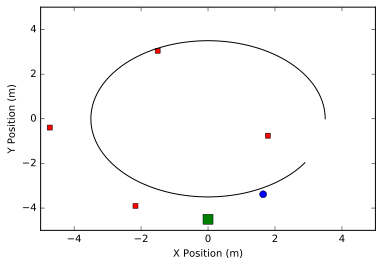

In [164]:
import scipy
import time
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

# First, some Jupyter plotting config
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

# measurement noise
RANGE_NOISE = 0.05
VELOCITY_NOISE = 1.0
RANGE_PROB = 0.35

# Some variables we'll need
state = state_init
P = P_init
t_last = times[0]
xy_last = path_xy[0]

# track our position estimates, so we can plot it
pos_estimates = []

for k in range(1, len(times)):
    # ===== GENERATE SIMULATED VELOCITY MEASUREMENTS =====
    # change in time
    t = times[k]
    dt = t - t_last
    t_last = t
    # change in position
    tru_xy = path_xy[k]
    dxy = tru_xy - xy_last
    xy_last = tru_xy
    # velocity with added noise
    vxy_est = dxy/dt + scipy.randn(1,2)*VELOCITY_NOISE
    
    # ===== WILL WE BE RECEIVING RANGE INFO? =====
    ranging = False
    if scipy.rand() < RANGE_PROB:
        ranging = True
    
    # ===== HANDLE INERTIAL ONLY =====
    if ranging == False:
        # get measurement vector
        z = np.matrix([
                [vxy_est.item(0)],
                [vxy_est.item(1)],
            ])

        # use time change to bind state process function
        fcn_state_bound = lambda s: fcn_state(s,dt)
        
        # use measurement type to bind measurement function
        fcn_meas_bound = lambda s: fcn_meas(s,MEASTYPE_INERTIAL,0)

        # kalman filter update
        state, P = ekfUpdate(fcn_state_bound, state, P, fcn_meas_bound, z, dt*Q, R_inert)
    
    else: # ===== HANDLE RANGE MEASUREMENTS =====
        # pick a random anchor
        anc_idx = np.random.randint(NUMANC)
        axy = anc_xy[anc_idx,:]
        
        # calculate noisy range
        range_est = np.linalg.norm([tru_xy - axy]) + scipy.randn()*RANGE_NOISE
        
        # get measurement vector
        z = np.matrix([
                [vxy_est.item(0)],
                [vxy_est.item(1)],
                [range_est]
            ])
        
        # use time change to bind state process function
        fcn_state_bound = lambda s: fcn_state(s,dt)
        
        # use measurement type to bind measurement function
        fcn_meas_bound = lambda s: fcn_meas(s,MEASTYPE_RANGE,anc_idx)

        # kalman filter update
        state, P = ekfUpdate(fcn_state_bound, state, P, fcn_meas_bound, z, dt*Q, R_range)
        
    # ===== PLOT ESTIMATED POSITIONS =====
    mob_est  = [state.item(0), state.item(1)]
    a0xy_est = [state.item(4), state.item(5)]
    a1xy_est = [state.item(6), state.item(7)]
    a2xy_est = [state.item(8), state.item(9)]
    a3xy_est = [state.item(10), state.item(11)]
    plt.clf()
    plt.plot(a0xy_est[0], a0xy_est[1], 'rs', markersize=5)
    plt.plot(a1xy_est[0], a1xy_est[1], 'rs', markersize=5)
    plt.plot(a2xy_est[0], a2xy_est[1], 'rs', markersize=5)
    plt.plot(a3xy_est[0], a3xy_est[1], 'rs', markersize=5)
    plt.plot(mob_est[0],  mob_est[1],  'bo', markersize=7)
    if anc_idx >= 0:
        plt.plot(anc_xy[anc_idx,0], anc_xy[anc_idx,1], 'gs', markersize=10)
    # plot true path
    plt.plot(path_xy[:,0], path_xy[:,1], 'k-')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.xlim(BOUNDX)
    plt.ylim(BOUNDY)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    # pause for visualization
    time.sleep(0.01)
                
print('Measurement time elapsed:', np.round(t_last - times[0]), 'sec.')

And we're done!